# Digit Recognition Task
If this is your first time running a notebook - welcome!! Notebooks are awesome because they let us play around and experiment
with code with near-instant feedback. Some pointers:
1. To execute a cell, click on it and hit SHIFT-Enter
2. Once something is executed, the variables are in memory - inspect them!

## Getting Started
This first cell imports the necessary libraries so we can get started:

In [ ]:
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.onnx as onnx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

 ## Data!
 Without data we really can't do anything with machine learning. At this point we have our sharp question **can we predict a digit given a 28x28 vector of numbers?**
 
 Once that is all squared away we need to take a look at our data. The next cell is a helper function that visualizes the the digits (a sanity check).


In [2]:
def draw_digits(digits):
    fig, axes = plt.subplots(6, 20, figsize=(18, 7),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        X, y = digits[i]
        ax.imshow(255 - X.reshape(28,28) * 255, cmap='gray')
        ax.set_title('{:.0f}'.format(torch.argmax(y).item()))

The next cell downloads the standard digit dataset (called MNIST). The `transform` and `target_transform` parts of this call add some conversion steps to make the data more suitable for the models we will try.

In [3]:
digits = datasets.MNIST('data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )

Here is our sanity check!

In [4]:
draw_digits(digits)

Feel free to take a look at the data by printing out `x` and/or `y`. They really are just numbers! A couple of things that might seem strange when you print them out:
1. "I thought you said the images were 784 sized vectors of 0-255???" - They were! We just normalized the vectors by dividing by 255 so the new range is 0-1 (it makes the numbers more tidy)
2. "I thought the `y` was a numerical answer?? Instead it's a 10 sized vector!" - Yes - this is called a one-hot encoding of the answer. Now there's a `1` in the index of the right answer. Again, this makes the math work a lot better for the models we will be creating.

In [5]:
x, y = digits[0]
print(x)
print(y)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

# Choosing Models
Now that we have some data it's time to start picking models we think might work. This is where the science part of data-science comes in: we guess and then check if our assumptions were right. Imagine models like water pipes that have to distribute water to 10 different hoses depending on 784 knobs. These 784 knobs represent the individual pixels in the digit and the 10 hoses at the end represent the actual number (or at least the index of the one with the most water coming out of it). Our job now is to pick the plumbing in between.

The next three cells represent three different constructions in an increasingly more complex order:

1. The first is a simple linear model,
2. The second is a 3 layer Neural Network,
3. and the last is a full convolutional neural network

While it is out of the scope of this tutorial to fully explain how they work, just imagine they are basically plumbing with internal knobs that have to be tuned to produce the right water pressure at the end to push the most water out of the right
index. As you go down each cell the plumbing and corresponding internal knobs just get more complicated.

In [6]:
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.layer1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.layer1(x)
        return F.softmax(x, dim=1)

In [7]:
class NeuralNework(nn.Module):
    def __init__(self):
        super(NeuralNework, self).__init__()
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 512)
        self.output = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)
        return F.softmax(x, dim=1)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Optimizing Model Parameters
Now that we have some models it's time to optimize the internal parameters to see if it can do a good job at recognizing digits! It turns out there are some parameters that we can give the optimization algorithm to tune how it trains - these are called hyper-parameters. That's what the two variables represent below:

In [9]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

The `learning_rate` basically specifies how fast the algorithm will learn the model parameters. Right now you're probably thinking "let's set it to fifty million #amirite?" The best analogy for why this is a bad idea is golf. I'm a terrible golfist (is that right?) so I don't really know anything - but pretend you are trying to sink a shot (again sorry) but can only hit the ball the same distance every time. Easy right? Hit it the exact length from where you are to the hole! Done! Now pretend you don't know where the hole is but just know the general direction. Now the distance you choose actually matters. If it is too long a distance you'll miss the hole, and then when you hit it back you'll overshoot again. If the distance is too small then it will take forever to get there but for sure you'll eventually get it in. Basically you have to guess what the right distance per shot should be and then try it out. That is basically what the learning rate does for finding the "hole in one" for the right parameters (ok, I'm done with the golf stuff).

Below there are three things that make this all work:
1. **The Model** - this is the function we're making that takes in the digit vector and should return the right number
2. **The Cost Function** (sometimes called the loss function). I know I promised I was done with golf but I lied. Remember how I said in our screwy golf game you knew the general direction of the hole? The cost function tells us the distance to the hole - when it's zero we're there! In actual scientific terms, the cost function tells us how bad the model is at getting the right answer. As we take shots you should see the cost function decreasing. If this does not happen then something is wrong. At this point I would change the shot distance (or `learning_rate`) to something smaller and try again. If that doesn't work maybe change the model!
3. **The Optimizer** - this part is the bit that actually changes the model parameters. It has a sense for the direction we should be shooting and updates all of the internal numbers inside the model to find the best internal knobs to predict the right digits. In this case I am using the Binary Cross Entropy cost function because, well, I know it works. There are a ton of different cost functions you can choose from that fit a variety of different scenarios.

In [10]:
# where to run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# selected model
model = SimpleLinear().to(device)
#model = NeuralNework().to(device)
#model = CNN().to(device)
print(model)

# cost function used to determine best parameters
cost = torch.nn.BCELoss()

# used to create optimal parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cuda device
SimpleLinear(
  (layer1): Linear(in_features=784, out_features=10, bias=True)
)


I forgot to mention the whole `cuda` thing. GPUs speed this whole process up because this is basically all a big Matrix multiplcation problem in a `for` loop. PyTorch is great because you basically need to tell the model where to run (either on the CPU or using CUDA - which is a platform for moving computations to the GPU).

Now for the learning part! The `dataloader`'s job is to iterate through the entire dataset (in this case 60,000 examples of digits and their corresponding label) but to take chunks of size `batch_size` of the data to process. This is another hyperparameter that needs to be chosen. `epochs` is the number of times we want to loop through the dataset in its entirety (again something we choose based upon how our experiment goes).

A word on how long this takes - it takes a while.

In [11]:
# loader
dataloader = DataLoader(digits, batch_size=batch_size, num_workers=0, pin_memory=True)

# golfing time!
for t in range(epochs):
    print('Epoch {}'.format(t))
    print('-------------------------------')
    # go through the entire dataset once
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        # zero out gradient
        optimizer.zero_grad()
        # make a prediction on this batch!
        pred = model(X)
        # how bad is it?
        loss = cost(pred, Y)
        # compute gradients
        loss.backward()
        # update parameters
        optimizer.step()
        
        if batch % 100 == 0:
            print('loss: {:>10f}  [{:>5d}/{:>5d}]'.format(loss.item(), batch * len(X), len(dataloader.dataset)))
            
    print('loss: {:>10f}  [{:>5d}/{:>5d}]\n'.format(loss.item(), len(dataloader.dataset), len(dataloader.dataset)))
    
print('Done!')

Epoch 0
-------------------------------
loss:   0.324714  [    0/60000]
loss:   0.120360  [ 6400/60000]
loss:   0.094450  [12800/60000]
loss:   0.082783  [19200/60000]
loss:   0.063817  [25600/60000]
loss:   0.072431  [32000/60000]
loss:   0.051376  [38400/60000]
loss:   0.082728  [44800/60000]
loss:   0.066302  [51200/60000]
loss:   0.073625  [57600/60000]
loss:   0.028484  [60000/60000]

Epoch 1
-------------------------------
loss:   0.052062  [    0/60000]
loss:   0.052166  [ 6400/60000]
loss:   0.045498  [12800/60000]
loss:   0.063747  [19200/60000]
loss:   0.042184  [25600/60000]
loss:   0.063963  [32000/60000]
loss:   0.036549  [38400/60000]
loss:   0.073531  [44800/60000]
loss:   0.055800  [51200/60000]
loss:   0.073686  [57600/60000]
loss:   0.020631  [60000/60000]

Epoch 2
-------------------------------
loss:   0.038994  [    0/60000]
loss:   0.047847  [ 6400/60000]
loss:   0.036883  [12800/60000]
loss:   0.056841  [19200/60000]
loss:   0.038674  [25600/60000]
loss:   0.0612

So what the heck did this actually do? Great question. I will explain this `SimpleLinear` model since its the on we ran first. We are basically learning one matrix and one vector. That's it (it's really anti-climacttic if you ask me). Let me show you why that actually does anything:

\begin{align}
prediction = W \cdot x + b
\end{align}

\begin{align}
\begin{bmatrix}
\hat{y}_1 \\ \vdots \\ \hat{y}_{10}
\end{bmatrix}_{10 \times 1} = 
\begin{bmatrix}
w_{1,1} &  \ldots &  w_{1,784} \\
\vdots    & \ddots &  \\
w_{10,1}  & \ldots & w_{10, 784} \\
\end{bmatrix}_{10 \times 784} 
\cdot
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_{783} \\ x_{784}\end{bmatrix}_{784 \times 1}
 + 
\begin{bmatrix}
b_1 \\ \vdots \\ b_{10}
\end{bmatrix}_{10 \times 1}
\end{align}


The matrix `W`and the vector `b` is what the `SimpleLinear` model learns. The output is a 10 by 1 matrix whose largest value is the index of the thing number we want to predict. Take a look at what the algorithm learned for the two variables (as well as the sizes):

In [12]:
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([10, 784])
Parameter containing:
tensor([[ 0.0272,  0.0349, -0.0094,  ..., -0.0113,  0.0137,  0.0301],
        [-0.0065, -0.0143, -0.0217,  ..., -0.0345, -0.0186, -0.0323],
        [-0.0179,  0.0171, -0.0058,  ..., -0.0124, -0.0091,  0.0289],
        ...,
        [ 0.0106, -0.0054, -0.0265,  ..., -0.0170, -0.0061,  0.0227],
        [ 0.0180, -0.0323,  0.0236,  ..., -0.0254,  0.0279,  0.0049],
        [ 0.0107, -0.0218,  0.0175,  ...,  0.0058, -0.0234, -0.0088]],
       device='cuda:0', requires_grad=True)
torch.Size([10])
Parameter containing:
tensor([-0.2599,  0.4166,  0.0458, -0.2472,  0.1208,  0.6905, -0.0332,  0.3545,
        -0.7617, -0.1192], device='cuda:0', requires_grad=True)


# Is it working???
The best way to figure out if it is working is to test the model on data the learning process hasn't used. Luckily we have such a dataset (it is basically a held out section of the data we already have used). I'm loading it all up the same way as before and printing them out to show you that they're different.

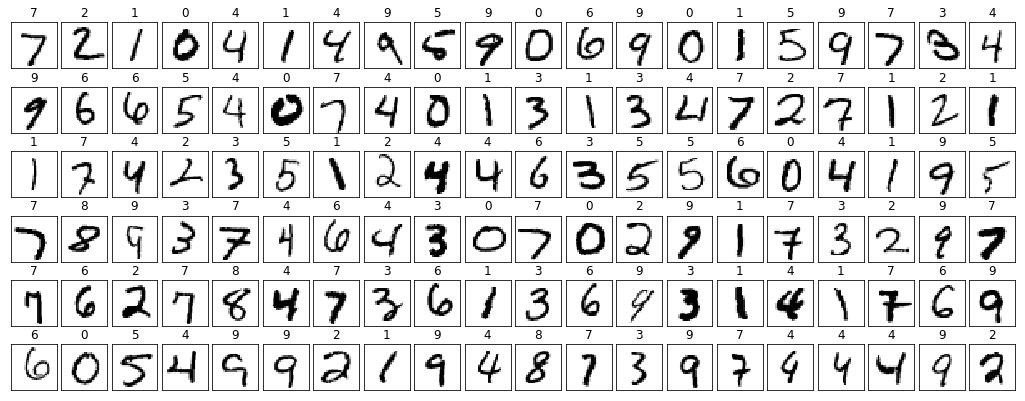

In [13]:
test_digits = datasets.MNIST('data', train=False, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.reshape(28*28))
                        ]),
                        target_transform=transforms.Compose([
                            transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, y, 1))
                        ])
                     )
draw_digits(test_digits)

Let's test it on the first digit above (the 7).

In [14]:
x, y = test_digits[0]
x = x.to(device).view(1, 28*28)

We'll tell the model we are using it for evaluation (sometimes called inference) and pass in our previously unseen digit.

In [15]:
model.eval()
with torch.no_grad():
    pred = model(x)
    pred = pred.to('cpu').detach()[0]
    
print(pred)

tensor([9.6284e-06, 1.5173e-10, 1.4951e-05, 1.7654e-03, 4.8513e-07, 1.5701e-05,
        2.4185e-09, 9.9783e-01, 1.8910e-05, 3.4010e-04])


Now let's see if the predicted digit matches the actual digit:

In [16]:
pred.argmax(0), y.argmax(0)

(tensor(7), tensor(7))

Let's see how well we do over *all* of the test data!

In [17]:
# data loader for test digits
test_dataloader = DataLoader(test_digits, batch_size=64, num_workers=0, pin_memory=True)

# set model to evaluation mode
model.eval()
test_loss = 0
correct = 0

# loop! 
with torch.no_grad():
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        pred = model(X)

        test_loss += cost(pred, Y).item()
        correct += (pred.argmax(1) == Y.argmax(1)).type(torch.float).sum().item()

test_loss /= len(dataloader.dataset)
correct /= len(dataloader.dataset)
print('\nTest Error:')
print('acc: {:>0.1f}%, avg loss: {:>8f}'.format(100*correct, test_loss))


Test Error:
acc: 92.6%, avg loss: 0.000700


# Saving the Model
Every framework is different - in this case PyTorch let's us save the model (which you remember is just a big matrix `W` and a vector `b`) to an internal format as well as to the ONNX format. These can then be loaded up as an asset to a program that is executed every time you need to recognize a digit!

In [18]:
# create dummy variable to traverse graph
x = torch.randint(255, (1, 28*28), dtype=torch.float).to(device) / 255
onnx.export(model, x, 'model.onnx')
print('Saved onnx model to model.onnx')

# saving PyTorch Model Dictionary
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch Model to model.pth')

Saved onnx model to model.onnx
Saved PyTorch Model to model.pth


# Play!
Now that you've gone through the whole process, please go back up to play around! Try changing:
1. The actual model! The other models are almost identical with the exception that they learn additional Matrices (W's and b's) that the images pass through to get the final answer.
2. The hyperparameters like `learning_rate`, `batch_size`, and `epoch`. Does it make things better or worse? 92% is ok, does any other combination of model's and hyperparamters fare better?

## Final Thoughts
Would love your feedback! Was this helpful? Any parts confusing? Drop me a line!